# A4: Autoencoders and RNNs

In [4]:
# Standard imports
import numpy as np
import Network as Network
import mnist_loader
import matplotlib.pylab as plt
%matplotlib inline
import copy

# Q1: Autoencoder

## (a) Derivative of Cosine Proximity

Loss function is
$$
C ( \vec{y} , \vec{t} ) = \frac{ - \left( \vec{y} \cdot \vec{t} \right) }{ \| \vec{y} \| \ \| \vec{t} \|}
$$
We are given that the output layer uses the identity mapping as an activation function, $\vec{y} = \vec{z}$.

YOUR ANSWER HERE

## (b) Implement Derivative of Cosine Proximity

In [5]:
# Cosine Proximity
def CosineProximity(y, t):
    '''
        C = CosineProximity(y, t)
        
        Evaluates the average cosine proximity for the batch.
        
        Inputs:
          y is a batch of samples, with samples stored in rows
          t is a batch of targets
          
        Output:
          C is the average cosine proximity (cost)
    '''
    C = -np.sum(y*t, axis=1)
    C /= np.linalg.norm(y, axis=1)
    C /= np.linalg.norm(t, axis=1)
    return np.sum(C) / Network.NSamples(y)


# CosineProximity_p
def CosineProximity_p(y, t):
    '''
        dCdy = CosineProximity_p(y, t)
        
        Computes the gradient of the cosine proximity cost function.
        
        Inputs:
          y is a batch of samples, with samples stored in rows
          t is a batch of targets
          
        Output:
          dCdy is an array the same size as y, holding the derivative
               of the cost with respect to each element in y
    '''
    # Row-wise norm
    norm_t, norm_y = np.linalg.norm(t, axis=1), np.linalg.norm(y, axis=1)
    
    C = -np.sum(y*t, axis=1)
    C /= norm_y
    C /= norm_t
    C = C.reshape(C.shape[0],1)
    
    dCdy = (-1.)*((t/(norm_t*norm_y)[:,None]) + (C*(y)/(np.square(norm_y[:,None]))))
    return dCdy
   

## (c) Create and Train a Network
You can make your network use your cost function and its derivative by setting the member variables,

    mynet.cost = CosineProximity
    mynet.cost_p = CosineProximity_p

In [4]:
# Read in 10000 MNIST samples
train, validate, test = mnist_loader.load_data_wrapper()
train_in = np.array(train[0][:10000])

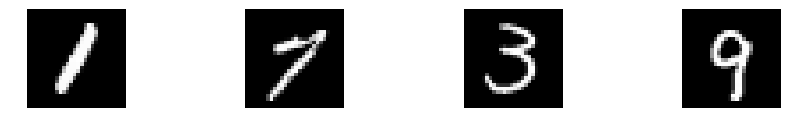

In [112]:
# Display some sample digit images
plt.figure(figsize=[15,4])
n_digits = 4
for n in range(n_digits):
    idx = np.random.randint(10000)
    plt.subplot(2,n_digits,n+1)
    plt.imshow(np.reshape(train_in[idx], [28,28]), cmap='gray'); plt.axis('off');

In [5]:
autoencoder_net = Network.Network()
autoencoder_net.cost = CosineProximity
autoencoder_net.cost_p = CosineProximity_p
autoencoder_net.AddLayer(Network.Layer(784))
autoencoder_net.AddLayer(Network.Layer(50, act='logistic'))
autoencoder_net.AddLayer(Network.Layer(784, act='identity'))

# Train the network
progress = autoencoder_net.SGD(train_in, train_in, epochs=60, lrate=1., batch_size=50)

test_in = np.array(test[0])
print('Training cost = '+str(autoencoder_net.Evaluate(train_in, train_in)))
print('    Test cost = '+str(autoencoder_net.Evaluate(test_in, test_in)))

Training cost = -0.9083278464369323
    Test cost = -0.9078785880079849


## (d) View Reconstructions

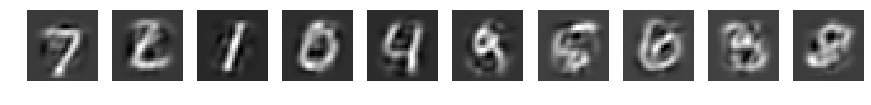

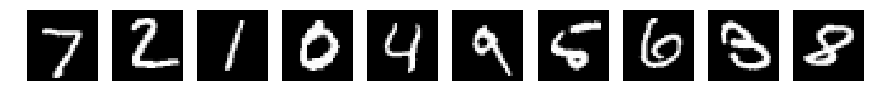

In [6]:
# Display some sample digit images
plt.figure(figsize=[15,10])
test_in, test_digit = np.array(test[0]), np.array(test[1])
n_digits = 10
output_images = autoencoder_net.FeedForward(test_in)
test_digits = set(np.arange(10))
idx = 0
valid_idxs = []
n = 0 
while(test_digits):
    if np.nonzero(test_digit[idx])[0][0] in test_digits:
        test_digits.remove(np.nonzero(test_digit[idx])[0][0])
        plt.subplot(2,n_digits,n+1)
        plt.imshow(np.reshape(output_images[idx], [28,28]), cmap='gray'); plt.axis('off');
        valid_idxs.append(idx)
        n+=1
    idx += 1
    
plt.figure(figsize=[15,10])
for  n in range(len(valid_idxs)):
    idx = valid_idxs[n]
    plt.subplot(2,n_digits,n+1)
    plt.imshow(np.reshape(test_in[idx], [28,28]), cmap='gray'); plt.axis('off');

# Q2: BPTT

## (a)

YOUR ANSWER HERE FOR $$\frac{\partial E}{\partial V}$$

## (b)

YOUR ANSWER HERE FOR $$\frac{\partial E}{\partial U}$$

## (c)

YOUR ANSWER HERE FOR $$\frac{\partial E}{\partial W}$$

## (d)

YOUR ANSWER HERE FOR  $$\frac{\partial E}{\partial b}$$

# Q3: RNN

## Read in the data

The code below creates two lists:
  - `sentences`, and
  - `next_chars`
  
Each list element represents a sequences of characters. There are 3 ways to represent a character:
1. As a string, eg. `'b'`
2. As an index to a character set, eg. `2`
3. As a one-hot vector, eg. `[0, 0, 1, 0, ...]`

The lists `sentences` and `next_chars` store the characters as indices (item 2 above). The utility functions
  - `char2vec`
  - `index2vec`
  - `vec2char`
  - `vec2index`
  
transform the characters between the 3 representations. You can also use the dictionaries `char_indices` and `indices_char` to convert between a string character and and index. The code below contains some examples.

In [6]:
import re
text = open('origin_of_species.txt').read().lower()
chars = sorted(list(set(text)))
chars.insert(0, "\0") #Add newline character
vocab_size = len(chars)

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
idx = [char_indices[c] for c in text]

# Let's simplify it by keeping only letters and spaces
filt_idx = []
for i in idx:
    if i<=24:
        filt_idx.append(2)
    elif i>24:
        filt_idx.append(i)
blah = ''.join([indices_char[f] for f in filt_idx])
text = re.sub(' +', ' ', blah)
chars = sorted(list(set(text)))
vocab_size = len(chars)
print('Character set: '+''.join(chars)+' (first char is a space)')

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
idx = [char_indices[c] for c in text]

print('There are '+str(vocab_size)+' characters in our character set')

''.join(indices_char[i] for i in idx[:70])

def char2vec(c):
    v = np.zeros(vocab_size)
    v[char_indices[c]] = 1.
    return v

def index2vec(i):
    v = np.zeros(vocab_size)
    v[i] = 1.
    return v

def vec2index(v):
    i = np.argmax(v)
    return i

def vec2char(v):
    return indices_char[vec2index(v)]

'''Form the dataset in sentences'''
sentences_length = 10
sentences = []
next_chars = []
for i in range(0, 10000 - sentences_length + 1):
    sentences.append(idx[i: i + sentences_length]) #Assume a sentence is made of X characters
    next_chars.append(idx[i + 1: i + sentences_length + 1]) #Offset by 1 to the right for the target

sentences = np.concatenate([[np.array(o)] for o in sentences[:-2]])
next_chars = np.concatenate([[np.array(o)] for o in next_chars[:-2]])
print(sentences.shape, next_chars.shape)

def read_sentence(idx):
    return ''.join(indices_char[i] for i in idx)

print('Here is how you can view one of the samples:')
print('Sample input: ['+read_sentence(sentences[0])+']')

Character set:  abcdefghijklmnopqrstuvwxyz (first char is a space)
There are 27 characters in our character set
(9989, 10) (9989, 10)
Here is how you can view one of the samples:
Sample input: [on the ori]


## Some utility functions

In [24]:
def sigma(z):
    return np.clip(z, a_min=0, a_max=None)  # ReLU
    #return 1./(1+np.exp(-z))  # use this for logistic

def sigma_primed(y):
    return np.clip(np.sign(y), a_min=0, a_max=1)  # Derivative of ReLU
    #return y*(1.-y)  # use this for logistic

def softmax(z):
    ez = np.exp(z)
    denom = np.sum(ez)
    return ez / denom

def CrossEntropy(y, t):
    return -sum(t*np.log(y))

## (a) Complete BPTT

In [31]:
class RNN():
    
    def __init__(self, dims, seq_length=10):
        '''
         Input:
           dims is [X, H, Y], where the input has layer has X neurons, the
                hidden layer has H neurons, and the output layer has Y neurons.
           seq_length is how many steps to unroll the RNN through time
                (this is the same as tau in the lecture notes)
        '''
        self.X, self.H, self.Y = dims
        self.seq_length = seq_length
        # Input layer
        self.xs = [np.zeros(self.X) for x in range(seq_length)] # activity
        # Hidden layer
        self.hs = [np.zeros(self.H) for x in range(seq_length)] # activity
        # Output layer
        self.ys = [np.zeros(self.Y) for x in range(seq_length)] # activity
        
        # Connection weights
        self.U = np.random.normal(size=[self.H, self.X])/np.sqrt(self.X) # input->hidden
        self.W = np.random.normal(size=[self.H, self.H])/np.sqrt(self.H) # hidden->hidden
        self.V = np.random.normal(size=[self.Y, self.H])/np.sqrt(self.H) # hidden->output
        self.b = np.zeros(self.H) # biases for hidden nodes
        self.c = np.zeros(self.Y) # biases for output nodes
        
    def ForwardTT(self, seq_in):
        '''
         i = ForwardTT(seq_in)
        
         Propagates the RNN forward through time, saving all the intermediate
         states that will be needed for backprop through time (BPTT).
        
         Input:
           seq_in is a vector of indecies, with self.seq_length elements.
        
         Output:
           i is the index of the character predicted to follow the input.
         
         This method's main purpose is to update the states of the activites
         in the time-unrolled network.
        '''
        self.xs[0] = index2vec(seq_in[0]) # convert to character vector
        
        # Starting input current for hidden nodes
        ss = np.dot(self.U, self.xs[0]) + self.b
        self.hs[0] = sigma(ss)  # Activation of hidden nodes
        
        # Input current for output nodes
        zs = np.dot(self.V, self.hs[0]) + self.c
        self.ys[0] = softmax(zs)  # Activation of output nodes
        
        # Now process forward in time
        for i in range(1, self.seq_length):
            self.xs[i] = index2vec(seq_in[i])  # input vector
            
            # Input current for hidden nodes, including recurrent connections
            ss = np.dot(self.U, self.xs[i]) + np.dot(self.W, self.hs[i-1]) + self.b
            self.hs[i] = sigma(ss)  # Activation
            
            # Input current for output nodes
            zs = np.dot(self.V, self.hs[i]) + self.c
            self.ys[i] = softmax(zs)  # Activation
            
        # Might as well output the final state of the output
        return vec2index(self.ys[-1])
    
    
    def BPTT(self, seq_in, seq_out):
        '''
         BPTT(seq_in, seq_out)
         
         Performs backprop through time on one sample given by the input and
         output sequence.
         
         Input:
           seq_in is a vector of indices specifying the input sequence of
                   characters.
           seq_out is a vector of indices specifying the output sequence of
                   characters. Typically, seq_out is the same as seq_in, but
                   shifted by 1 character.
         
         Output:
           None, but the connection weights and biases are updated.
        '''
        # Initialize gradients to zero
        self.dEdV = np.zeros(np.shape(self.V))
        self.dEdW = np.zeros(np.shape(self.W))
        self.dEdU = np.zeros(np.shape(self.U))
        self.dEdb = np.zeros(np.shape(self.b))
        self.dEdc = np.zeros(np.shape(self.c))
        
        #=========#
        dE_dh_up =  np.zeros(np.shape(self.H)) #Keep track of dEdh
        for i in range(self.seq_length-1,-1,-1):
            y_vec = self.ys[i]
            t_vec = index2vec(seq_out[i])
            dEdz = y_vec - t_vec
            
            self.dEdV = np.outer(dEdz, self.hs[i]) # should be of the same size as dEdV
            
            dEdh_total = np.dot(self.V.T, dEdz) # shape: Hx1
            dEdh = np.dot(self.V.T, dEdz)
            if i < self.seq_length - 1: 
                dEdh += np.dot(self.W.T,sigma_primed(self.hs[i+1])*dE_dh_up)
                self.dEdW += np.outer(sigma_primed(self.hs[i+1])*dE_dh_up,self.hs[i])  
        
            self.dEdU += np.outer((dEdh * sigma_primed(self.hs[i])), self.xs[i]) # HxX
            self.dEdb += dEdh*sigma_primed(self.hs[i])
            self.dEdc += dEdz
            
            dE_dh_up = dEdh
            
    def Generate(self, n=1):
        '''
         c = Generate(n=1)
         
         Runs the RNN from the last state after running ForwardTT, outputting
         the next n characters.
         
         Input:
           n is the number of characters you want to predict
           
         Output:
           c is a string of n characters
        '''
        y = self.ys[-1]  # Final output of ForwardTT
        c = vec2char(y)  # Convert it to a character string
        h = self.hs[-1]  # Starting with last hidden state...
        # Loop forward in time
        # (no need to record states, since we won't be doing BPTT)
        for nn in range(n-1):
            x = copy.copy(y)  # Use last output as next input
            
            # Input current for hidden nodes
            s = np.dot(self.U, x) + np.dot(self.W, h) + self.b
            h = sigma(s)  # Activation
            
            # Input current for output nodes
            z = np.dot(self.V, h) + self.c
            y = softmax(z)  # Activation
            
            # And add the next character to our output string
            c += vec2char(y)
            
        return c
            
    def Evaluate(self, train_in, train_out):
        '''
         loss = Evaluate(train_in, train_out)
         
         Evaluates the network on the supplied dataset.
         
         Input:
           train_in is a list of input sequences (see ForwardTT for format of input)
           train_out is the corresponding list of output sequences
           
         Output:
           loss is the average cross entropy
        '''
        val = 0.
        for x, t in zip(train_in, train_out):
            self.ForwardTT(x)
            for i in range(self.seq_length):
                val += CrossEntropy(self.ys[i], index2vec(t[i]))
        return val/len(train_in)
            
    def Train(self, train_in, train_out, kappa=0.05, epochs=1):
        '''
         Train(train_in, train_out, kappa=0.05, epochs=1)
         
         Performs epochs of gradient descent, performing BPTT after each sample.
         
         Input:
           train_in and train_out is the training dataset
           kappa is the learning rate
           epochs is the number of times to go through the dataset
           
         Output:
           None, but the connection weights and biases are updated
        '''
        # Loop over epochs
        for e in range(epochs):
            
            # Shuffle the training data
            data_shuffled = list(zip(train_in, train_out))
            np.random.shuffle(data_shuffled)
            
            for x, t in data_shuffled:
                self.ForwardTT(x)  # Forward through time
                self.BPTT(x, t)    # Backprop through time
                # Note that BPTT starts by resetting the gradients to zero.
                
                # Apply update to connection weights and biases
                self.V -= kappa*self.dEdV
                self.U -= kappa*self.dEdU
                self.W -= kappa*self.dEdW
                self.b -= kappa*self.dEdb
                self.c -= kappa*self.dEdc

            print('Epoch '+str(e)+', Loss = '+str(self.Evaluate(train_in, train_out)))

## (b) Create the RNN

In [32]:
# YOUR CODE HERE
net = RNN([27,400,27])

## (c) Train

In [ ]:
# YOUR CODE HERE
# for i in range(3):
#     net.Train(sentences, next_chars, epochs=5, kappa=0.0005)
net.Train(sentences, next_chars, epochs=15, kappa=0.001)

Epoch 0, Loss = 22.707604405797873
Epoch 1, Loss = 20.450537192005275
Epoch 2, Loss = 19.034985978823812
Epoch 3, Loss = 18.0122822775968
Epoch 4, Loss = 17.343868820648396
Epoch 5, Loss = 16.57424812964964


In [10]:
# You might opt to have more than one train command, using different
# learning rates and numbers of epochs. Each one builds on the results
# from the last run.
#net.Train(...)

## (d) Evaluate

In [ ]:
# A sample continuation.
n = 38
b.ForwardTT(sentences[n])
blah = read_sentence(sentences[n])
print('Input:      '+blah)
print('Prediction: '+blah+b.Generate(5))
print('Actual:     '+blah+read_sentence(sentences[n+10]))

In [183]:
blah = 'harles dar'
x = [char_indices[c] for c in blah]
b.ForwardTT(x)
print(blah)
print(blah+b.Generate(10))

harles dar
harles darwin istr c


In [12]:
# YOUR CODE HERE